<a href="https://colab.research.google.com/github/ashfarhangi/Real-Time-Systems/blob/master/Memory_Generator_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing libraries
# All codes are garbage
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import time
sns.set()
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

def get_memory(file):
#   open for reading
    with open(file, 'r') as fileopen:
        data = fileopen.read()
#       for spliting the numbers
    data = data.split()
#     print(data)
# this is for finding duplicates and where the memeroy has duplicates occuring
    vocab = list(set(data))
    return data, vocab
# Easy way to use the recurring memories in this case:
#   We can one hot encode the words such as a word "the" would be onehot[1,the]=1
def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)
    for i in range(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    return onehot

In [0]:
text, text_vocab = get_memory('/content/gdrive/My Drive/Colab Notebooks/data/memory_r.txt')
print("Duplicates: ",len(text_vocab)-len(text))

Duplicates:  0


In [0]:
#Modeling:
learning_rate = 0.01
batch_size = 30
sequence_length = 60
epoch = 150
num_layers = 2
size_layer = 256
possible_batch_id = range(len(text) - sequence_length - 1)
print('possible batch',possible_batch_id)
print(len(text))

possible batch range(0, 1939)
2000


In [0]:
class Model:
#    LSTM CELL
# Dimention = (2000) Lengh of text can build multi diementional text as well
    def __init__(self, num_layers, size_layer, dimension, sequence_length, learning_rate):
        def lstm_cell():
#         LSTMCELL(256,60)
            return tf.nn.rnn_cell.LSTMCell(size_layer, sequence_length, state_is_tuple = False)
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
#         Weights = (256,2000)
        rnn_W = tf.Variable(tf.random_normal((size_layer, dimension)))
#         Bias = (2000)
        rnn_B = tf.Variable(tf.random_normal([dimension]))
#   z = Xw+b
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
#      the vector of raw (non-normalized) predictions that a classification model generates
# Means applying softmax to reduce the cost
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
#     If the two numbers are exactly the same it is a correct predict
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
W0627 14:38:27.006222 140257390757760 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f8f6a0d3f60>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0627 14:38:27.007993 140257390757760 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7f8f6a0d3f98>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.


#Encoding:

In [0]:
def seq2seq():
    SoftMaxLoss, FinalAccuracy = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = embed_to_onehot([text[k + n] for k in batch_id], text_vocab)
            id2 = embed_to_onehot([text[k + n + 1] for k in batch_id], text_vocab)
            batch_x[:,n,:] = id1
            batch_y[:,n,:] = id2
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        FinalAccuracy.append(accuracy); SoftMaxLoss.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return SoftMaxLoss, FinalAccuracy

In [0]:
SoftMaxLoss, FinalAccuracy = seq2seq()

epoch: 100%|██████████| 150/150 [00:41<00:00,  3.61it/s, accuracy=0.241, cost=4.46]


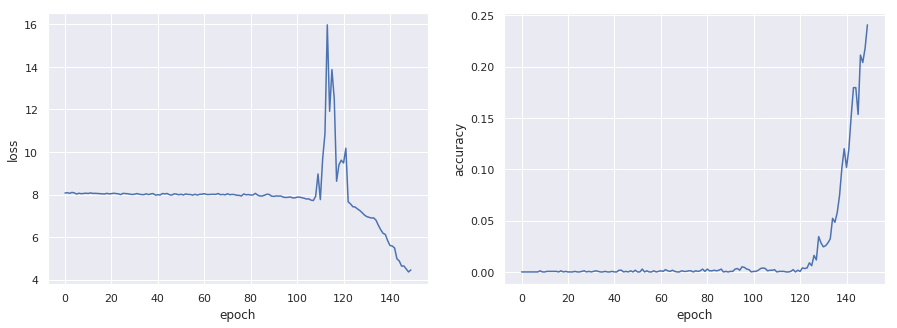

In [0]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(SoftMaxLoss))
plt.plot(EPOCH, SoftMaxLoss)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, FinalAccuracy)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [0]:
split_text = text
# selected_index = np.random.randint(0, len(split_text) - 5)
selected_index =1990
tag = split_text[selected_index:selected_index + 10]
print(tag)


['1899', '2066', '197400', '201175', '218035', '285025', '130469', '229028', '186735', '241621']


#Decoding:

In [0]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[i, :]
#         IMPORTANT
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            index = np.argmax(prob[0][0])
        else:
            index = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[index]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[0, :]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)


In [0]:
print(generate_based_sequence(10,True))

1899 2066 197400 201175 218035 285025 130469 229028 186735 241621 227928 1007 130389 240485 240485 216888 200029 200029 196287 283873


In [0]:
print(generate_based_sequence(10,False))

1899 2066 197400 201175 218035 285025 130469 229028 186735 241621 216118 284174 228843 200415 1054 195573 1739 199202 284295 196889


In [0]:
ytest=[2076
,1909
,197410
,201185
,218045
,285035
,130479
,229038
,186745
,2086]
print(ytest)

[2076, 1909, 197410, 201185, 218045, 285035, 130479, 229038, 186745, 2086]


In [0]:
arg1 = generate_based_sequence(10,True)
arg4 = generate_based_sequence(10,False)

In [0]:
arg4 = arg4.split()

arg3 = arg1.split()
#     print(data)
# this is for finding duplicates and where the memeroy has duplicates occuring
arg3 = list(set(arg3))
for i in range(len(arg3)):
  arg3[i] = int(arg3[i])
arg4 = list(set(arg4))
for i in range(len(arg4)):
  arg4[i] = int(arg4[i])

In [0]:
arg2 = text[1990:2000]
# arg2 =pd.DataFrame(arg2)
for i in range(len(arg2)):
  arg2[i] = int(arg2[i])

In [0]:
ytest=[2076
,1909
,197410
,201185
,218045
,285035
,130479
,229038
,186745
,2086]

In [0]:
print(ytest)
print(arg3[10:])
print(arg4[10:])

[2076, 1909, 197410, 201185, 218045, 285035, 130479, 229038, 186745, 2086]
[229028, 241621, 1007, 200029, 130389, 196287, 240485, 201175]
[195850, 197400, 218035, 1899, 229028, 241621, 196926, 201175, 227413, 200752]


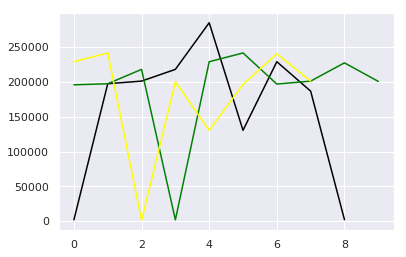

In [0]:
plt.plot(ytest[1:],c='black')
plt.plot(arg4[10:],c='green')
plt.plot(arg3[10:],c='yellow')
plt.show()

References:
https://towardsdatascience.com/aifortrading-2edd6fac689d